In [186]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from matplotlib import pyplot as plt
import time

Load Data:

In [187]:
df = pd.read_csv("Wednesday-workingHours.pcap_ISCX.csv")
print(df.shape)

(692703, 79)


Clean cols + synthesize timestamps:

In [188]:
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.date_range(
    start="2017-07-07 15:00:00", periods=len(df), freq="10ms"
)
df = df.set_index('Timestamp')

In [189]:
df['packets'] = df['Total Fwd Packets'] + df['Total Backward Packets']
df['bytes']   = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']

# Keep robust & interpretable features
keep = [
    # Volume
    'packets',
    'bytes',

    # Port fan-out
    'Destination Port',

    # Size statistics
    'Packet Length Mean',
    'Packet Length Std',
    'Packet Length Variance',
    'Min Packet Length',
    'Max Packet Length',

    # TCP flags
    'SYN Flag Count',
    'ACK Flag Count',
    'FIN Flag Count',
    'RST Flag Count',
    'PSH Flag Count',
    'ECE Flag Count',

    # Subflow burstiness
    'Subflow Fwd Packets',
    'Subflow Bwd Packets',

    # Truth
    'Label'
]

df = df[keep]
df.head()

,packets,bytes,Destination Port,Packet Length Mean,Packet Length Std,Packet Length Variance,Min Packet Length,Max Packet Length,SYN Flag Count,ACK Flag Count,FIN Flag Count,RST Flag Count,PSH Flag Count,ECE Flag Count,Subflow Fwd Packets,Subflow Bwd Packets,Label
Timestamp,,,,,,,,,,,,,,,,,
2017-07-07 15:00:00.000,2,12,80,6.000000,0.000000,0.000000,6,6,0,1,0,0,0,0,1,1,BENIGN
2017-07-07 15:00:00.010,16,498,389,29.294118,56.529599,3195.595588,0,163,0,0,0,0,1,0,11,5,BENIGN
2017-07-07 15:00:00.020,16,6300,88,370.588235,671.751541,451250.132400,0,1575,0,0,0,0,1,0,10,6,BENIGN
2017-07-07 15:00:00.030,29,10112,389,337.066667,704.654082,496537.374700,0,3069,0,0,0,0,1,0,17,12,BENIGN
2017-07-07 15:00:00.040,15,6302,88,393.875000,704.585067,496440.116700,0,1576,0,0,0,0,1,0,9,6,BENIGN


In [190]:
agg = df.resample("5s").agg({
    'packets':'sum',
    'bytes':'sum',
    'Destination Port':'nunique',

    'Packet Length Mean':'mean',
    'Packet Length Std':'mean',
    'Packet Length Variance':'mean',
    'Min Packet Length':'mean',
    'Max Packet Length':'mean',

    'SYN Flag Count':'sum',
    'ACK Flag Count':'sum',
    'FIN Flag Count':'sum',
    'RST Flag Count':'sum',
    'PSH Flag Count':'sum',
    'ECE Flag Count':'sum',

    'Subflow Fwd Packets':'sum',
    'Subflow Bwd Packets':'sum',

    'Label': lambda x: (x!='BENIGN').mean()
})

In [206]:
agg['is_attack'] = (agg['Label'] > 0.5).astype(int)

In [192]:
agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)

In [193]:
Z_cols = ['packets','bytes','Destination Port']
zs = (agg[Z_cols] - agg[Z_cols].mean()) / agg[Z_cols].std()

# absolute deviation across dims
agg['z_score'] = zs.abs().sum(axis=1)

# threshold empirically:
agg['z_anomaly'] = (agg['z_score'] > 0.75).astype(int)

In [202]:
dos_features = [
    'packets',
    'bytes',
    'Packet Length Mean',
    'Packet Length Std',
    'SYN Flag Count',
    'ACK Flag Count',
    'FIN Flag Count',
    'RST Flag Count'
]

scaler = StandardScaler()
X = StandardScaler().fit_transform(agg[dos_features])

IF = IsolationForest(
    contamination=0.08,   # higher contamination
    n_estimators=300,
    random_state=42
)
agg['if_anomaly'] = IF.fit_predict(X)
agg['if_anomaly'] = (agg['if_anomaly'] == -1).astype(int)

In [203]:
print("Label counts in agg:")
print(agg['is_attack'].value_counts())

print("\nZ anomaly counts:")
print(agg['z_anomaly'].value_counts())

from sklearn.metrics import confusion_matrix
print("\nConfusion matrix for Z-score:")
print(confusion_matrix(agg['is_attack'], agg['z_anomaly']))

Label counts in agg:
is_attack
0    874
1    512
Name: count, dtype: int64

Z anomaly counts:
z_anomaly
1    994
0    392
Name: count, dtype: int64

Confusion matrix for Z-score:
[[368 506]
 [ 24 488]]


In [204]:
def metrics(name, pred):
    print(f"\n=== {name} ===")
    print("Precision:", precision_score(agg['is_attack'], agg[pred]))
    print("Recall:   ", recall_score(agg['is_attack'], agg[pred]))
    print("F1:       ", f1_score(agg['is_attack'], agg[pred]))


# baseline statistical
metrics("Z-Score", 'z_anomaly')

# ML:
metrics("IsolationForest (DDoS)", 'if_anomaly')



=== Z-Score ===
Precision: 0.4909456740442656
Recall:    0.953125
F1:        0.648074369189907

=== IsolationForest (DDoS) ===
Precision: 0.7297297297297297
Recall:    0.158203125
F1:        0.26003210272873195


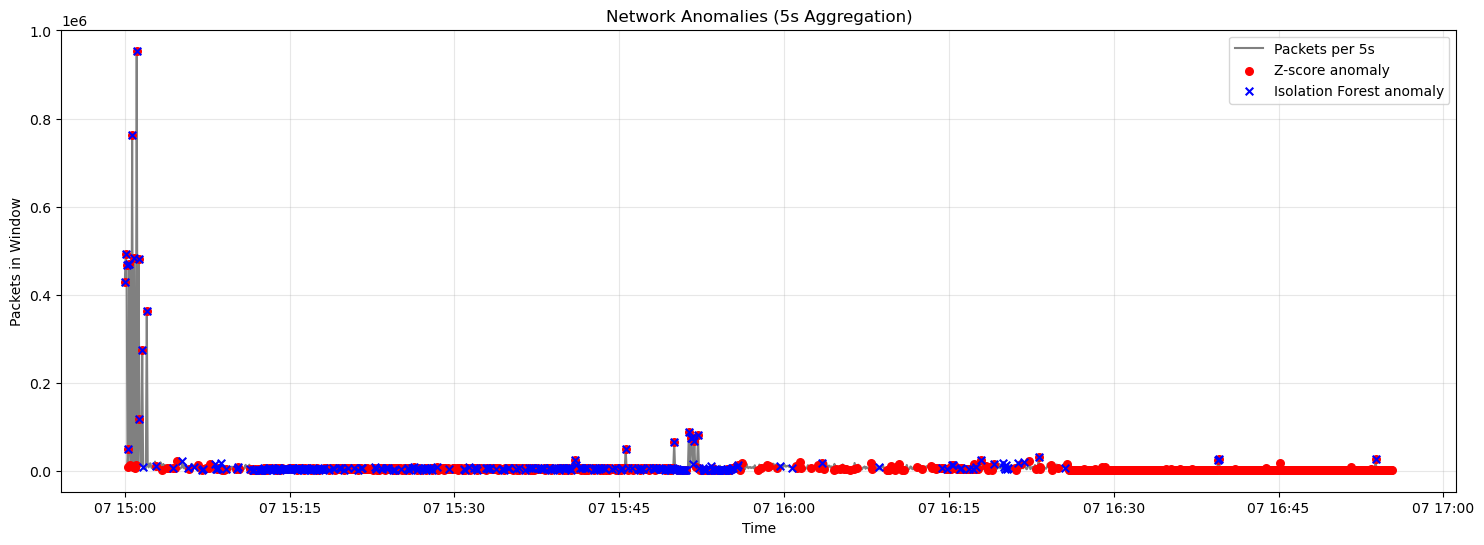

In [197]:
plt.figure(figsize=(18,6))

plt.plot(
    agg.index,
    agg['packets'],
    color='grey',
    label='Packets per 5s'
)

plt.scatter(
    agg.index[agg['z_anomaly'] == 1],
    agg['packets'][agg['z_anomaly'] == 1],
    color='red',
    s=30,
    label='Z-score anomaly',
    zorder=3
)

plt.scatter(
    agg.index[agg['if_anomaly'] == 1],
    agg['packets'][agg['if_anomaly'] == 1],
    color='blue',
    s=30,
    marker='x',
    label='Isolation Forest anomaly',
    zorder=4
)

plt.title("Network Anomalies (5s Aggregation)")
plt.xlabel("Time")
plt.ylabel("Packets in Window")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [198]:
print("\n=== Real-Time Anomaly Simulation ===\n")

for ts, row in agg.iterrows():
    if row['if_anomaly'] or row['z_anomaly']:
        print(
            f"[ALERT] {ts} | "
            f"packets={row['packets']} | "
            f"ports={row['Destination Port']} | "
            f"SYN={row['SYN Flag Count']} | "
            f"attack={row['is_attack']}"
        )
        time.sleep(0.05)


=== Real-Time Anomaly Simulation ===

[ALERT] 2017-07-07 15:00:00 | packets=429253.0 | ports=76.0 | SYN=39.0 | attack=0.0
[ALERT] 2017-07-07 15:00:05 | packets=493786.0 | ports=83.0 | SYN=34.0 | attack=0.0
[ALERT] 2017-07-07 15:00:10 | packets=466878.0 | ports=102.0 | SYN=71.0 | attack=0.0
[ALERT] 2017-07-07 15:00:15 | packets=8641.0 | ports=97.0 | SYN=47.0 | attack=0.0
[ALERT] 2017-07-07 15:00:20 | packets=49951.0 | ports=86.0 | SYN=35.0 | attack=0.0
[ALERT] 2017-07-07 15:00:25 | packets=469375.0 | ports=103.0 | SYN=40.0 | attack=0.0
[ALERT] 2017-07-07 15:00:30 | packets=14327.0 | ports=108.0 | SYN=61.0 | attack=0.0
[ALERT] 2017-07-07 15:00:40 | packets=762043.0 | ports=71.0 | SYN=43.0 | attack=0.0
[ALERT] 2017-07-07 15:00:45 | packets=9768.0 | ports=105.0 | SYN=68.0 | attack=0.0
[ALERT] 2017-07-07 15:00:50 | packets=484587.0 | ports=88.0 | SYN=61.0 | attack=0.0
[ALERT] 2017-07-07 15:00:55 | packets=7634.0 | ports=156.0 | SYN=39.0 | attack=0.0
[ALERT] 2017-07-07 15:01:00 | packets=13

KeyboardInterrupt: 